# Case study: re-analysis of nematode (*Caenorhabditis elegans*) single-cell data

This notebook will demonstrate scRNA-seq processing with `orthomap` using nematode scRNA data from ([Packer and Zhu al., 2019](https://doi.org/10.1126/science.aax1971)).

scRNA data were obtained from [https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE126954](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE126954), converted into Scanpy `AnnData` objects ([Wolf et al., 2018](https://doi.org/10.1186/s13059-017-1382-0)) and are availabe here:

[https://doi.org/10.5281/zenodo.7245547](https://doi.org/10.5281/zenodo.7245547)

or can be accessed with the `dataset` submodule of `orthomap`

`datasets.packer19(datapath='data')` (download folder set to `'data'`).

## Notebook file

Notebook file can be obtained here:

[https://raw.githubusercontent.com/kullrich/orthomap/main/docs/notebooks/nematode_example.ipynb](https://raw.githubusercontent.com/kullrich/orthomap/main/docs/notebooks/nematode_example.ipynb)

## Steps

To process the scRNA data, we will do the following:

0. Use pre-calculated gene age classification
1. Get query species taxonomic lineage information
2. Get query species orthomap
3. Map OrthoFinder gene names and scRNA gene/transcript names
4. Get TEI values and add them to scRNA dataset
5. Get partial TEI values to visualize gene age class contributions
6. Process scRNA data and visualize TEI

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
# increase dpi
%matplotlib inline
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams['figure.figsize'] = [4.4, 3.3]

## Import orthomap python package submodules

In [2]:
# import submodules
from orthomap import qlin, gtf2t2g, of2orthomap, orthomap2tei, datasets

## step 0 - Use pre-calculated gene age classification

Orthomap was pre-calculated ([Sun et al., 2021](https://doi.org/10.1101/gr.275303.121)) and is available here:

[https://doi.org/10.5281/zenodo.7242263](https://doi.org/10.5281/zenodo.7242263)

or can be accessed with the `dataset` submodule of `orthomap`

`datasets.sun21_orthomap(datapath='data')` (download folder set to `'data'`).

If you want to use your own OrthoFinder results:

`orthomap` can extract gene age classification from existing OrthoFinder results and link them with scRNA data.

A detailed how-to is available here:

https://orthomap.readthedocs.io/en/latest/tutorials/orthofinder.html

In [3]:
# download pre-calculated orthomap into data folder
datasets.sun21_orthomap(datapath='data')

100% [............................................................................] 344640 / 344640

'data/Sun2021_Orthomap.tsv'

## step 0 - Use different pre-calculated evolutionary indices

Diversity parameter were pre-calculated ([Ma et al., 2021](https://doi.org/10.1093/gbe/evab048)) and is available here:

[https://doi.org/10.5281/zenodo.7242263](https://doi.org/10.5281/zenodo.7242263)

or can be accessed with the `dataset` submodule of `orthomap`

`datasets.ma21_orthomap(datapath='data')` (download folder set to `'data'`).

In [4]:
# download pre-calculated evolutionay indices into data folder
datasets.ma21_fst(datapath='data')

100% [..........................................................................] 1049100 / 1049100

'data/Ma2021_Fst.tsv'

## step 1 - Get query species taxonomic lineage information

Given a species name or taxonomic ID, the query species lineage information is extracted with the help of the `ete3` python toolkit and the `NCBI taxonomy` ([Huerta-Cepas et al., 2016](https://doi.org/10.1093/molbev/msw046)). This information is needed alongside with the taxonomic classifications for all species used in the OrthoFinder comparison.

The `orthomap` submodule `qlin` helps to get this information for you with the `qlin.get_qlin()` function as follows:

In [5]:
# get query species taxonomic lineage information
query_lineage = qlin.get_qlin(q='Caenorhabditis elegans')

query name: Caenorhabditis elegans
query taxID: 6239
query kingdom: Eukaryota
query lineage names: 
['root(1)', 'cellular organisms(131567)', 'Eukaryota(2759)', 'Opisthokonta(33154)', 'Metazoa(33208)', 'Eumetazoa(6072)', 'Bilateria(33213)', 'Protostomia(33317)', 'Ecdysozoa(1206794)', 'Nematoda(6231)', 'Chromadorea(119089)', 'Rhabditida(6236)', 'Rhabditina(2301116)', 'Rhabditomorpha(2301119)', 'Rhabditoidea(55879)', 'Rhabditidae(6243)', 'Peloderinae(55885)', 'Caenorhabditis(6237)', 'Caenorhabditis elegans(6239)']
query lineage: 
[1, 131567, 2759, 33154, 33208, 6072, 33213, 33317, 1206794, 6231, 119089, 6236, 2301116, 2301119, 55879, 6243, 55885, 6237, 6239]


## step 2 - Get query species orthomap

Orthomap was pre-calculated ([Sun et al., 2021](https://doi.org/10.1101/gr.275303.121); see Figure 3B) it is also available here:

[https://doi.org/10.5281/zenodo.7242263](https://doi.org/10.5281/zenodo.7242263)

or can be accessed with the `dataset` submodule of `orthomap`

`datasets.sun21_orthomap(datapath='data')` (download folder set to `'data'`).

The pre-calculated orthomap can be imported from the `orthomap2tei` submodule with the `orthomap2tei.read_orthomap()` function as follows:

In [6]:
# get query species orthomap

# download pre-calculated orthomap here: https://doi.org/10.5281/zenodo.7242263
# or download with datasets.sun21_orthomap(datapath='data')
query_orthomap = orthomap2tei.read_orthomap(orthomapfile='data/Sun2021_Orthomap.tsv')
query_orthomap

GeneID  Phylostratum
0      WBGene00000001             1
1      WBGene00000002             1
2      WBGene00000003             1
3      WBGene00000004             1
4      WBGene00000005             2
...               ...           ...
20035  WBGene00305132             9
20036  WBGene00305157             1
20037  WBGene00305158            13
20038  WBGene00305159            11
20039  WBGene00305173             0

[20040 rows x 2 columns]

### Get query species evolutionary indices

In [7]:
# get query species Fst values

# download pre-calculated Fst values here: https://doi.org/10.5281/zenodo.7242263
# or download with datasets.ma21_fst(datapath='data')
query_fst = pd.read_csv('data/Ma2021_Fst.tsv', delimiter='\t')
query_fst

WormBase_ID  Chr       Gene  TajimaD  NormalizedPi   FayWu     FST
0      WBGene00000001    I      aap-1  -0.6957        0.0002 -1.2575  0.8062
1      WBGene00000002   IV      aat-1  -0.4724        0.0001 -1.4628  0.8846
2      WBGene00000003    V      aat-2  -1.5266        0.0001  0.0816  0.1691
3      WBGene00000004    X      aat-3  -1.6401        0.0003 -4.7685  0.8129
4      WBGene00000005   IV      aat-4  -1.2137        0.0006 -0.7617  0.3725
...               ...  ...        ...      ...           ...     ...     ...
20217  WBGene00271701    X   F10D7.10  -0.7428        0.0000 -1.9308  0.1111
20218  WBGene00271703  III  ZK1010.12  -1.3386        0.0008 -3.2528  0.7683
20219  WBGene00271706   II    D2089.8  -0.8312        0.0012  0.4489  0.5551
20220  WBGene00271707    V   ZK105.14  -1.0748        0.0004 -3.2069  0.6433
20221  WBGene00271715  III   B0244.17  -0.6617        0.0010 -1.1870  0.6556

[20222 rows x 7 columns]

#### Group evolutionary indices into bins

In [8]:
# see here for additional quantile methods: https://numpy.org/doc/stable/reference/generated/numpy.nanquantile.html

orthomap2tei.get_bins(tobin_df=query_fst,
                      bincol='TajimaD',
                      q=[.1, .2, .3, .4, .5, .6, .7, .8, .9],
                      method='median_unbiased')
orthomap2tei.get_bins(tobin_df=query_fst,
                      bincol='NormalizedPi',
                      q=[.2, .4, .6, .8],
                      method='median_unbiased')
orthomap2tei.get_bins(tobin_df=query_fst,
                      bincol='FayWu',
                      q=[.1, .2, .3, .4, .5, .6, .7, .8, .9],
                      method='median_unbiased')
orthomap2tei.get_bins(tobin_df=query_fst,
                      bincol='FST',
                      q=[.2, .4, .6, .8],
                      method='median_unbiased')

WormBase_ID  Chr       Gene  TajimaD  NormalizedPi   FayWu     FST  \
0      WBGene00000001    I      aap-1  -0.6957        0.0002 -1.2575  0.8062   
1      WBGene00000002   IV      aat-1  -0.4724        0.0001 -1.4628  0.8846   
2      WBGene00000003    V      aat-2  -1.5266        0.0001  0.0816  0.1691   
3      WBGene00000004    X      aat-3  -1.6401        0.0003 -4.7685  0.8129   
4      WBGene00000005   IV      aat-4  -1.2137        0.0006 -0.7617  0.3725   
...               ...  ...        ...      ...           ...     ...     ...   
20217  WBGene00271701    X   F10D7.10  -0.7428        0.0000 -1.9308  0.1111   
20218  WBGene00271703  III  ZK1010.12  -1.3386        0.0008 -3.2528  0.7683   
20219  WBGene00271706   II    D2089.8  -0.8312        0.0012  0.4489  0.5551   
20220  WBGene00271707    V   ZK105.14  -1.0748        0.0004 -3.2069  0.6433   
20221  WBGene00271715  III   B0244.17  -0.6617        0.0010 -1.1870  0.6556   

       TajimaD_binned                          TajimaD_bins  \
0                 8.0                 -0.84 >= x < -0.67368   
1                 9.0  -0.67368 >= x < -0.20841999999999972   
2                 3.0    -1.6187 >= x < -1.4602466666666667   
3                 2.0                -1.8383 >= x < -1.6187   
4                 5.0                -1.3196 >= x < -1.1656   
...               ...                                   ...   
20217             8.0                 -0.84 >= x < -0.67368   
20218             4.0    -1.4602466666666667 >= x < -1.3196   
20219             8.0                 -0.84 >= x < -0.67368   
20220             6.0                -1.1656 >= x < -1.0416   
20221             9.0  -0.67368 >= x < -0.20841999999999972   

       NormalizedPi_binned     NormalizedPi_bins  FayWu_binned  \
0                      3.0  0.0002 >= x < 0.0004           5.0   
1                      2.0  0.0001 >= x < 0.0002           5.0   
2                      2.0  0.0001 >= x < 0.0002           8.0   
3                      3.0  0.0002 >= x < 0.0004           2.0   
4                      4.0  0.0004 >= x < 0.0011           6.0   
...                    ...                   ...           ...   
20217                  1.0            x < 0.0001           4.0   
20218                  4.0  0.0004 >= x < 0.0011           3.0   
20219                  5.0            0.0011 < x          10.0   
20220                  4.0  0.0004 >= x < 0.0011           3.0   
20221                  4.0  0.0004 >= x < 0.0011           5.0   

                                           FayWu_bins  FST_binned  \
0                            -1.68402 >= x < -0.99135         5.0   
1                            -1.68402 >= x < -0.99135         5.0   
2      0.03219333333333343 >= x < 0.10182000000000008         3.0   
3       -9.455993333333332 >= x < -3.9512999999999994         5.0   
4                                 -0.99135 >= x < 0.0         4.0   
...                                               ...         ...   
20217              -2.277410000000001 >= x < -1.68402         2.0   
20218   -3.9512999999999994 >= x < -2.277410000000001         5.0   
20219                          0.2674900000000009 < x         4.0   
20220   -3.9512999999999994 >= x < -2.277410000000001         5.0   
20221                        -1.68402 >= x < -0.99135         5.0   

                   FST_bins  
0                0.6286 < x  
1                0.6286 < x  
2      0.1347 >= x < 0.3595  
3                0.6286 < x  
4      0.3595 >= x < 0.6286  
...                     ...  
20217     0.0 >= x < 0.1347  
20218            0.6286 < x  
20219  0.3595 >= x < 0.6286  
20220            0.6286 < x  
20221            0.6286 < x  

[20222 rows x 15 columns]

### Gene age assignments per query species lineage node

Given an orthomap, one can get an overview of the gene age assignments per query species lineage node.

The `orthomap` submodule `of2orhomap` and the `of2orthomap.get_counts_per_ps()` function will show the distribution of the gene age classes and can be further visualized as follows:

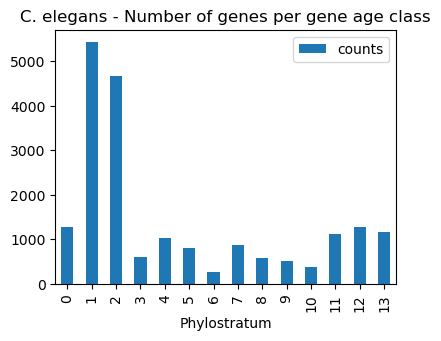

In [9]:
# show count per taxonomic group (PStaxID)
of2orthomap.get_counts_per_ps(omap_df=query_orthomap,
    psnum_col='Phylostratum',
    pstaxid_col=None,
    psname_col=None)

# bar plot count per taxonomic group (PSname)
ax = of2orthomap.get_counts_per_ps(omap_df=query_orthomap,
    psnum_col='Phylostratum',
    pstaxid_col=None,
    psname_col=None).plot.bar(y='counts', x='Phylostratum')
ax.set_title('C. elegans - Number of genes per gene age class')
plt.show()

#### Gene assignments per query species evolutionary index

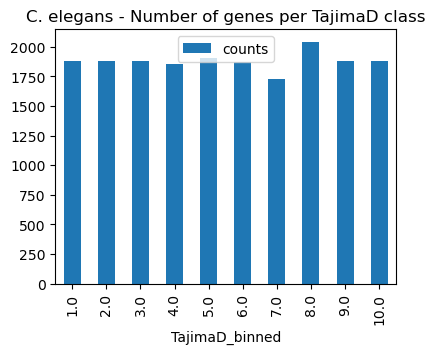

In [10]:
# show count per TajimaD group (TajimaD_binned)
of2orthomap.get_counts_per_ps(omap_df=query_fst,
    psnum_col='TajimaD_binned',
    pstaxid_col=None,
    psname_col=None)

# bar plot count per taxonomic group (PSname)
ax = of2orthomap.get_counts_per_ps(omap_df=query_fst,
    psnum_col='TajimaD_binned',
    pstaxid_col=None,
    psname_col=None).plot.bar(y='counts', x='TajimaD_binned')
ax.set_title('C. elegans - Number of genes per TajimaD class')
plt.show()

## step 3 - Map OrthoFinder gene names and scRNA gene/transcript names

To be able to link gene ages assignments from an orthomap and gene or transcript of scRNA dataset, one needs to check the overlap of the annotated gene names. With the `gtf2t2g` submodule of `orthomap` and the `gtf2t2g.parse_gtf()` function, one can extract gene and transcript names from a given gene feature file (`GTF`).

Here, pre-calculated orthomap gene names already overlap, so no `GTF` import is necessary ([Sun et al., 2021](https://doi.org/10.1101/gr.275303.121)).

### Import now, the scRNA dataset of the query species

Here, data is used, like in the original publication ([Packer and Zhu al., 2019](https://doi.org/10.1126/science.aax1971)).

scRNA data were downloaded from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE126954 converted into Seurat object and converted into loom and AnnData (h5ad) files to be able to analyse with e.g. python scanpy or orthomap package and is availbale here:

https://doi.org/10.5281/zenodo.7245547

or can be accessed with the `dataset` submodule of `orthomap`:

`datasets.packer19(datapath='data')` (download folder set to `'data'`).

__Note:__ A smaller scRNA data set for the same data exist and can be obtained via:

`datasets.packer19_small(datapath='data')` (download folder set to `'data'`).

In [11]:
# load scRNA data

# download zebrafish scRNA data here: https://doi.org/10.5281/zenodo.7245547
# or download with datasets.packer19('data')

#celegans_data = datasets.packer19(datapath='data')
celegans_data = sc.read('data/GSE126954.h5ad')

### Get an overview of observations

In [12]:
celegans_data

AnnData object with n_obs × n_vars = 89701 × 20222
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted'
    var: 'features', 'genes'

In [13]:
celegans_data.obs

orig.ident  nCount_RNA  nFeature_RNA  \
AAACCTGAGACAATAC-300.1.1           0      1630.0           781   
AAACCTGAGGGCTCTC-300.1.1           0      2323.0          1116   
AAACCTGAGTGCGTGA-300.1.1           0      3725.0          1322   
AAACCTGAGTTGAGTA-300.1.1           0      4236.0          1747   
AAACCTGCAAGACGTG-300.1.1           0      1003.0           621   
...                              ...         ...           ...   
TCTGAGACATGTCGAT-b02               0       581.0           361   
TCTGAGACATGTCTCC-b02               0       516.0           327   
TGGCCAGCACGAAGCA-b02               0       843.0           543   
TGGCGCACAGGCAGTA-b02               0       634.0           397   
TGGGCGTTCAGGCCCA-b02               0      1126.0           702   

                                              cell  n.umi   time.point  \
AAACCTGAGACAATAC-300.1.1  AAACCTGAGACAATAC-300.1.1   1630  300_minutes   
AAACCTGAGGGCTCTC-300.1.1  AAACCTGAGGGCTCTC-300.1.1   2319  300_minutes   
AAACCTGAGTGCGTGA-300.1.1  AAACCTGAGTGCGTGA-300.1.1   3719  300_minutes   
AAACCTGAGTTGAGTA-300.1.1  AAACCTGAGTTGAGTA-300.1.1   4251  300_minutes   
AAACCTGCAAGACGTG-300.1.1  AAACCTGCAAGACGTG-300.1.1   1003  300_minutes   
...                                            ...    ...          ...   
TCTGAGACATGTCGAT-b02          TCTGAGACATGTCGAT-b02    585        mixed   
TCTGAGACATGTCTCC-b02          TCTGAGACATGTCTCC-b02    510        mixed   
TGGCCAGCACGAAGCA-b02          TGGCCAGCACGAAGCA-b02    843        mixed   
TGGCGCACAGGCAGTA-b02          TGGCGCACAGGCAGTA-b02    636        mixed   
TGGGCGTTCAGGCCCA-b02          TGGGCGTTCAGGCCCA-b02   1132        mixed   

                                          batch  Size_Factor  \
AAACCTGAGACAATAC-300.1.1  Waterston_300_minutes     1.023195   
AAACCTGAGGGCTCTC-300.1.1  Waterston_300_minutes     1.458210   
AAACCTGAGTGCGTGA-300.1.1  Waterston_300_minutes     2.338283   
AAACCTGAGTTGAGTA-300.1.1  Waterston_300_minutes     2.659051   
AAACCTGCAAGACGTG-300.1.1  Waterston_300_minutes     0.629610   
...                                         ...          ...   
TCTGAGACATGTCGAT-b02                 Murray_b02     0.364709   
TCTGAGACATGTCTCC-b02                 Murray_b02     0.323907   
TGGCCAGCACGAAGCA-b02                 Murray_b02     0.529174   
TGGCGCACAGGCAGTA-b02                 Murray_b02     0.397979   
TGGGCGTTCAGGCCCA-b02                 Murray_b02     0.706820   

                                       cell.type    cell.subtype  \
AAACCTGAGACAATAC-300.1.1        Body_wall_muscle  BWM_head_row_1   
AAACCTGAGGGCTCTC-300.1.1                      NA              NA   
AAACCTGAGTGCGTGA-300.1.1                      NA              NA   
AAACCTGAGTTGAGTA-300.1.1        Body_wall_muscle    BWM_anterior   
AAACCTGCAAGACGTG-300.1.1  Ciliated_amphid_neuron             AFD   
...                                          ...             ...   
TCTGAGACATGTCGAT-b02                Rectal_gland    Rectal_gland   
TCTGAGACATGTCTCC-b02                          NA              NA   
TGGCCAGCACGAAGCA-b02                          NA              NA   
TGGCGCACAGGCAGTA-b02                          NA              NA   
TGGGCGTTCAGGCCCA-b02                          NA              NA   

                          plot.cell.type  raw.embryo.time  embryo.time  \
AAACCTGAGACAATAC-300.1.1  BWM_head_row_1              360        380.0   
AAACCTGAGGGCTCTC-300.1.1              NA              260        220.0   
AAACCTGAGTGCGTGA-300.1.1              NA              270        230.0   
AAACCTGAGTTGAGTA-300.1.1    BWM_anterior              260        280.0   
AAACCTGCAAGACGTG-300.1.1             AFD              350        350.0   
...                                  ...              ...          ...   
TCTGAGACATGTCGAT-b02        Rectal_gland              390        700.0   
TCTGAGACATGTCTCC-b02                  NA              510        470.0   
TGGCCAGCACGAAGCA-b02                  NA              400        470.0   
TGGCGCACAGGCAGTA-b

In [14]:
celegans_data.obs.dtypes

orig.ident                                   int32
nCount_RNA                                 float64
nFeature_RNA                                 int32
cell                                        object
n.umi                                        int32
time.point                                category
batch                                     category
Size_Factor                                float64
cell.type                                 category
cell.subtype                              category
plot.cell.type                            category
raw.embryo.time                              int32
embryo.time                                float64
embryo.time.bin                           category
raw.embryo.time.bin                       category
lineage                                   category
passed_initial_QC_or_later_whitelisted       int32
dtype: object

Prior any analysis the observations `'embryo.time.bin'` and `'batch'` will be converted into the `'category'` type. In addition a new observation `'cell.type.per.embryo.time.bin.cat'` will be created that combines sample timepoint and assigned cell type.

In [15]:
# add embryo.time.bin as category
celegans_data.obs['embryo.time.bin.cat'] = celegans_data.obs['embryo.time.bin'].astype('category')
celegans_data.obs['embryo.time.bin.cat'] = celegans_data.obs['embryo.time.bin.cat'].cat.reorder_categories(['< 100',
    '100-130','130-170','170-210','210-270','270-330','330-390','390-450','450-510','510-580','580-650','> 650'])
celegans_data.obs['batch.cat'] = celegans_data.obs['batch'].astype('category')


In [16]:
celegans_data.obs['cell.type.per.embryo.time.bin.cat'] =\
    (celegans_data.obs['cell.type'].astype('string') +\
    '-' +\
    celegans_data.obs['embryo.time.bin.cat'].astype('string')).astype('category')

### Helper functions to match gene names

The `orthomap2tei` submodule contains the `orthomap2tei.geneset_overlap()` helper function to check for gene name overlap between the constructed orthomap from `OrthoFinder` results and a given scRNA dataset.

In [17]:
# check overlap of orthomap <seqID> and scRNA data <var_names>
orthomap2tei.geneset_overlap(geneset1=celegans_data.var_names,
                             geneset2=query_orthomap['GeneID'])

g1_g2_overlap  g1_ratio  g2_ratio
0          19795  0.978884  0.987774

## step 4 - Get TEI values and add them to scRNA dataset

Since now the gene names correspond to each other in the orthomap and the scRNA `adata` object, one can calculate the transcriptome evolutionary index (`TEI`) and add them to the scRNA dataset (`adata` object).

The `TEI` measure represents the weighted arithmetic mean (expression levels as weights for the phylostratum value) over all evolutionary age categories denoted as _phylostra_.

${TEI_s = \sum (e_is * ps_i) / \sum e_is}$

, where ${TEI_s}$ denotes the `TEI` value in developmental stage ${s, e_is}$ denotes the gene expression level of gene ${i}$ in stage ${s}$, and ${ps_i}$ denotes the corresponding phylostratum of gene ${i, i = 1,...,N}$ and ${N = total\ number\ of\ genes}$.

Note: If e.g. two different isoforms would fall into two different gene age classes, their gene ages might differ based on the oldest ortholog found in their corresponding orthologous groups. However, both isoforms share the same gene name and their gene ages would clash. In this case one can decide either to use the `keep='min'` or `keep='max'` gene age to be kept by the `get_tei` function, which defaults to keep in this cases the `keep='min'` or in other words the 'older' gene age.

To be able to re-use the original `count` data, they are added as a new `layer` to the `adata` object. This is useful because later on the `count` data can be used to extract either the relative expression per gene age class. 

This can be done either on un-normalized `counts`, on `normalized` and `log-transformed` data.

In [18]:
celegans_data.layers['counts'] = celegans_data.X

### add TEI to adata object

Using the submodule `orthomap2tei` from `orthomap` and the `orthomap2tei.get_tei()` function, transcriptome evolutionary index (`TEI`) values are calculated and directyl added to the existing `adata` object (`add_obs=True`).

There are other options to e.g. not start from the `adata.X` `counts` but from another `layer` from the `adata` object, the default is to use the `adata.X` (`layer=None`). The values can be pre-processed by the `normalize_total` option and the `log1p` option.

If `add_obs=True` the resulting `TEI` values are added to the existing `adata` object as a new observation with the name set with the `obs_name` option.

If `add_var=True` the gene age values are added to the existing `adata` object as a new variable with the name set with the `var_name` option.

__Note:__ Genes not assigned to any gene class will get a missing assignment.

If one wants to calculate bootstrap `TEI` values per cell, the `boot` option can be set to `boot=True` and gene age classes will be randomly chosen prior calculating `TEI` values `bt=10` times.

In [19]:
# add TEI values to existing adata object
orthomap2tei.get_tei(adata=celegans_data,
    gene_id=query_orthomap['GeneID'],
    gene_age=query_orthomap['Phylostratum'],
    keep='min',
    layer=None,
    add_var=True,
    var_name='Phylostrata',
    add_obs=True,
    obs_name='tei',
    boot=False,
    bt=10,
    normalize_total=False,
    log1p=False,
    target_sum=1e6)

tei
AAACCTGAGACAATAC-300.1.1  1.942769
AAACCTGAGGGCTCTC-300.1.1  2.373868
AAACCTGAGTGCGTGA-300.1.1  2.367034
AAACCTGAGTTGAGTA-300.1.1  2.657920
AAACCTGCAAGACGTG-300.1.1  2.919836
...                            ...
TCTGAGACATGTCGAT-b02      1.948097
TCTGAGACATGTCTCC-b02      2.145631
TGGCCAGCACGAAGCA-b02      2.190024
TGGCGCACAGGCAGTA-b02      2.528481
TGGGCGTTCAGGCCCA-b02      2.234458

[89701 rows x 1 columns]

### add TajimaD, Fst and NormalizedPi to adata object

In [20]:
# add TajimaD binned values to existing adata object
orthomap2tei.get_tei(adata=celegans_data,
    gene_id=query_fst['WormBase_ID'],
    gene_age=query_fst['TajimaD_binned'],
    keep='min',
    layer=None,
    add_var=True,
    var_name='TajimaD_bin',
    add_obs=True,
    obs_name='TajimaD',
    boot=False,
    bt=10,
    normalize_total=False,
    log1p=False,
    target_sum=1e6)

TajimaD
AAACCTGAGACAATAC-300.1.1  6.025224
AAACCTGAGGGCTCTC-300.1.1  6.030407
AAACCTGAGTGCGTGA-300.1.1  5.798588
AAACCTGAGTTGAGTA-300.1.1  5.878986
AAACCTGCAAGACGTG-300.1.1  5.728000
...                            ...
TCTGAGACATGTCGAT-b02      5.708940
TCTGAGACATGTCTCC-b02      5.724891
TGGCCAGCACGAAGCA-b02      5.629842
TGGCGCACAGGCAGTA-b02      5.622061
TGGGCGTTCAGGCCCA-b02      5.820956

[89701 rows x 1 columns]

In [21]:
# add Fst binned values to existing adata object
orthomap2tei.get_tei(adata=celegans_data,
    gene_id=query_fst['WormBase_ID'],
    gene_age=query_fst['FST_binned'],
    keep='min',
    layer=None,
    add_var=True,
    var_name='FST_bin',
    add_obs=True,
    obs_name='Fst',
    boot=False,
    bt=10,
    normalize_total=False,
    log1p=False,
    target_sum=1e6)

Fst
AAACCTGAGACAATAC-300.1.1  2.780368
AAACCTGAGGGCTCTC-300.1.1  2.935859
AAACCTGAGTGCGTGA-300.1.1  3.011007
AAACCTGAGTTGAGTA-300.1.1  2.906988
AAACCTGCAAGACGTG-300.1.1  2.930209
...                            ...
TCTGAGACATGTCGAT-b02      3.166954
TCTGAGACATGTCTCC-b02      3.224806
TGGCCAGCACGAAGCA-b02      2.977461
TGGCGCACAGGCAGTA-b02      2.970032
TGGGCGTTCAGGCCCA-b02      3.081705

[89701 rows x 1 columns]

In [22]:
# add NormalizedPi binned values to existing adata object
orthomap2tei.get_tei(adata=celegans_data,
    gene_id=query_fst['WormBase_ID'],
    gene_age=query_fst['NormalizedPi_binned'],
    keep='min',
    layer=None,
    add_var=True,
    var_name='NormalizedPi_bin',
    add_obs=True,
    obs_name='NormalizedPi',
    boot=False,
    bt=10,
    normalize_total=False,
    log1p=False,
    target_sum=1e6)

NormalizedPi
AAACCTGAGACAATAC-300.1.1      2.093865
AAACCTGAGGGCTCTC-300.1.1      2.610418
AAACCTGAGTGCGTGA-300.1.1      2.562953
AAACCTGAGTTGAGTA-300.1.1      2.544381
AAACCTGCAAGACGTG-300.1.1      2.788634
...                                ...
TCTGAGACATGTCGAT-b02          2.320138
TCTGAGACATGTCTCC-b02          2.792636
TGGCCAGCACGAAGCA-b02          2.587189
TGGCGCACAGGCAGTA-b02          2.796530
TGGGCGTTCAGGCCCA-b02          2.520426

[89701 rows x 1 columns]

## step 5 - downstream analysis

Once the gene age data has been added to the scRNA dataset, one can e.g. plot the corresponding transcriptome evolutionary index (`TEI`) values by any given observation pre-defined in the scRNA dataset.

Here, we plot them against the assigned sample timepoint and against assigned cell types of the nematode using the `scanpy` `sc.pl.violin()` function as follows:

### Boxplot gene age class per sample timepoint
corresponds to main figure Figure 1D

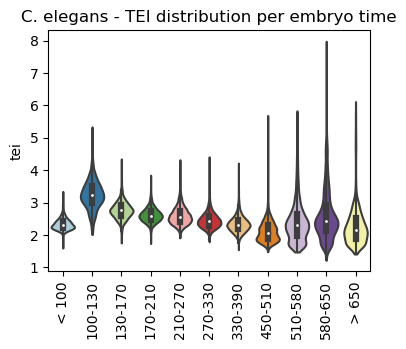

In [23]:
ax = sc.pl.violin(adata=celegans_data,
                  keys=['tei'],
                  groupby='embryo.time.bin.cat',
                  rotation=90,
                  palette='Paired',
                  stripplot=False,
                  inner='box',
                  order=['< 100', '100-130', '130-170', '170-210',
                         '210-270', '270-330', '330-390', '450-510',
                         '510-580', '580-650', '> 650'],
                  show=False)
ax.set_title('C. elegans - TEI distribution per embryo time')
plt.show()

### Boxplot TajimaD class per sample timepoint

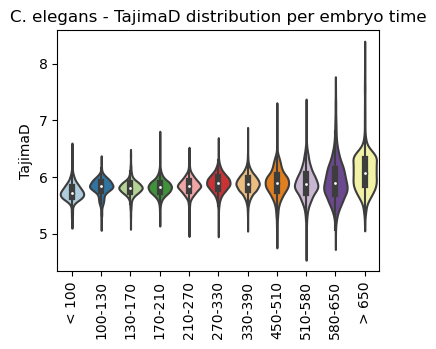

In [24]:
ax = sc.pl.violin(adata=celegans_data,
                  keys=['TajimaD'],
                  groupby='embryo.time.bin.cat',
                  rotation=90,
                  palette='Paired',
                  stripplot=False,
                  inner='box',
                  order=['< 100', '100-130', '130-170', '170-210',
                         '210-270', '270-330', '330-390', '450-510',
                         '510-580', '580-650', '> 650'],
                  show=False)
ax.set_title('C. elegans - TajimaD distribution per embryo time')
plt.show()

### Boxplot Fst class per sample timepoint

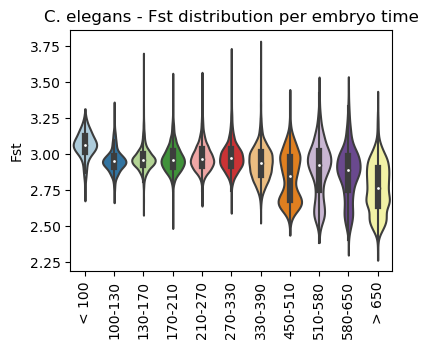

In [25]:
ax = sc.pl.violin(adata=celegans_data,
                  keys=['Fst'],
                  groupby='embryo.time.bin.cat',
                  rotation=90,
                  palette='Paired',
                  stripplot=False,
                  inner='box',
                  order=['< 100', '100-130', '130-170', '170-210',
                         '210-270', '270-330', '330-390', '450-510',
                         '510-580', '580-650', '> 650'],
                  show=False)
ax.set_title('C. elegans - Fst distribution per embryo time')
plt.show()

### Boxplot NormalizedPi class per sample timepoint

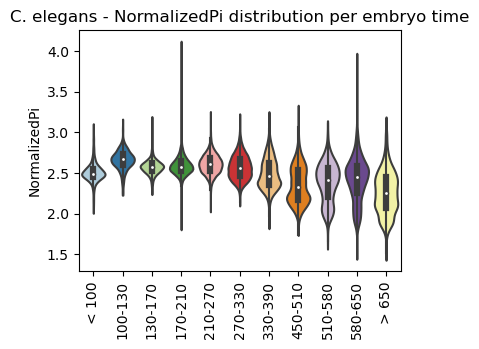

In [26]:
ax = sc.pl.violin(adata=celegans_data,
                  keys=['NormalizedPi'],
                  groupby='embryo.time.bin.cat',
                  rotation=90,
                  palette='Paired',
                  stripplot=False,
                  inner='box',
                  order=['< 100', '100-130', '130-170', '170-210',
                         '210-270', '270-330', '330-390', '450-510',
                         '510-580', '580-650', '> 650'],
                  show=False)
ax.set_title('C. elegans - NormalizedPi distribution per embryo time')
plt.show()

### Boxplot gene age class per sample timepoint and add significance

__Note:__ Please change notebook cell from `raw` to `code` to see the plots.

### Boxplot gene age class per sample timepoint and per cell type

E.g. to just show the same plot for a selected cell-type, one could do the following.

1. List all annotated cell types:

In [27]:
list(set(celegans_data.obs['cell.type']))

['Excretory_cell',
 'Intestine',
 'Body_wall_muscle',
 'G2_and_W_blasts',
 'hyp1V_and_ant_arc_V',
 'ABarpaaa_lineage',
 'Parent_of_hyp1V_and_ant_arc_V',
 'Parent_of_exc_duct_pore_DB_1_3',
 'Glia',
 'Ciliated_amphid_neuron',
 'NA',
 'Germline',
 'Excretory_gland',
 'hmc_homolog',
 'hmc',
 'Seam_cell',
 'GLR',
 'Rectal_gland',
 'Ciliated_non_amphid_neuron',
 'Arcade_cell',
 'Pharyngeal_neuron',
 'T',
 'hmc_and_homolog',
 'Pharyngeal_gland',
 'Pharyngeal_intestinal_valve',
 'Coelomocyte',
 'Rectal_cell',
 'M_cell',
 'Pharyngeal_marginal_cell',
 'Excretory_duct_and_pore',
 'Pharyngeal_muscle',
 'Intestinal_and_rectal_muscle',
 'XXX',
 'Hypodermis',
 'Parent_of_exc_gland_AVK',
 'Z1_Z4',
 'Excretory_cell_parent']

2. Loop over all cell types:

__Note:__ Please change notebook cell from `raw` to `code` to see the plots.

### Scatterplot TEI vs TajimaD and color each cell by sample timepoint per cell type

__Note:__ Please change notebook cell from `raw` to `code` to see the plots.

### Scatterplot TEI vs Fst and color each cell by sample timepoint  per cell type

__Note:__ Please change notebook cell from `raw` to `code` to see the plots.

### Scatterplot TEI vs NormalizedPi and color each cell by sample timepoint per cell type

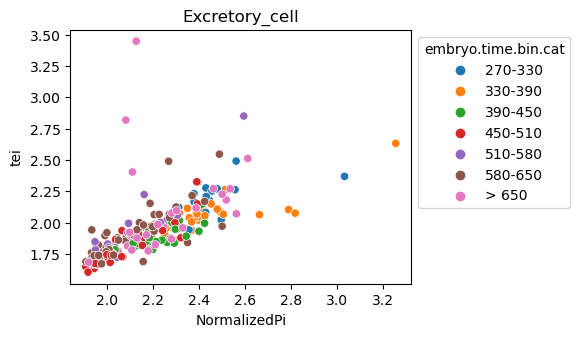

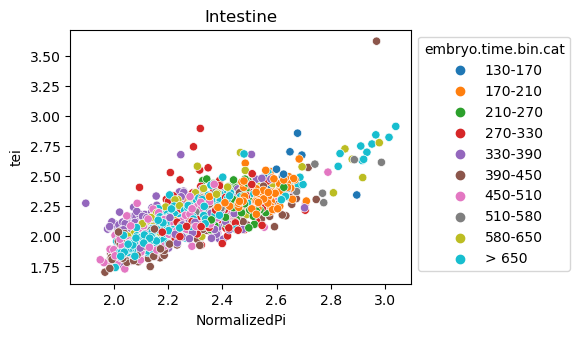

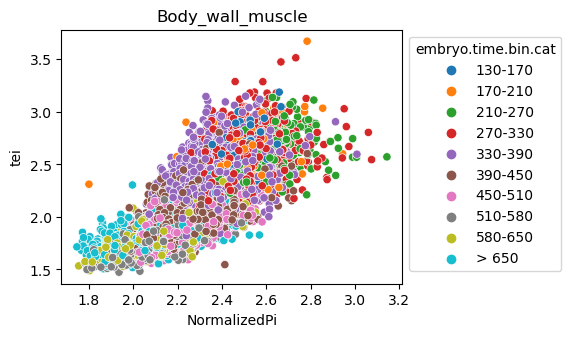

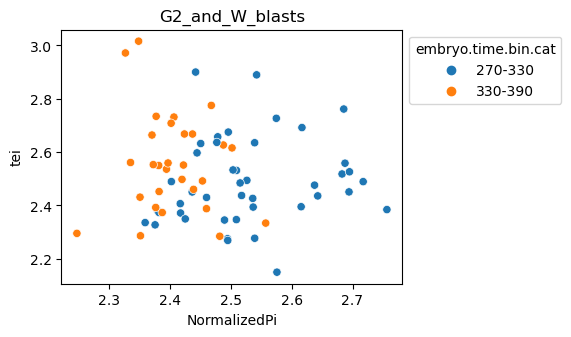

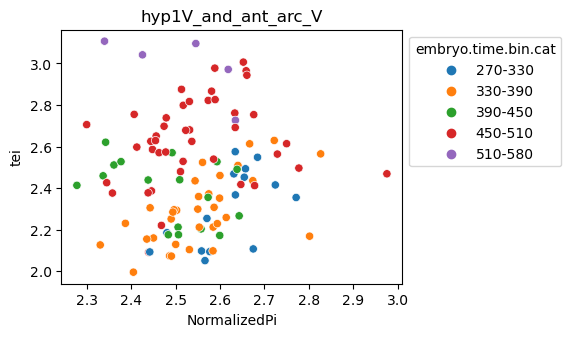

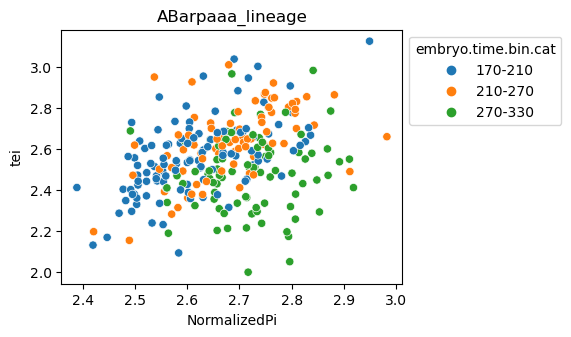

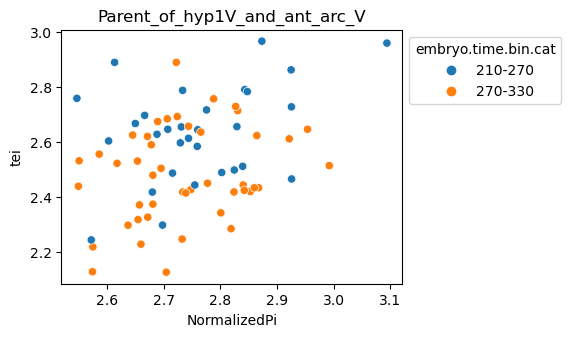

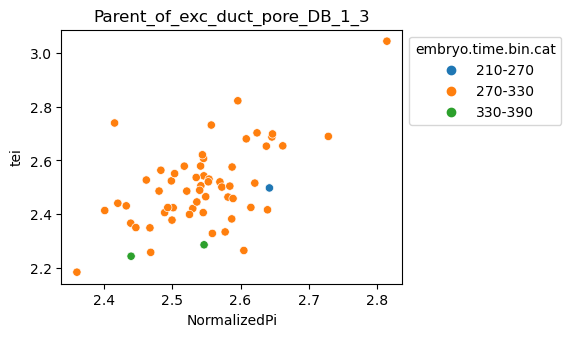

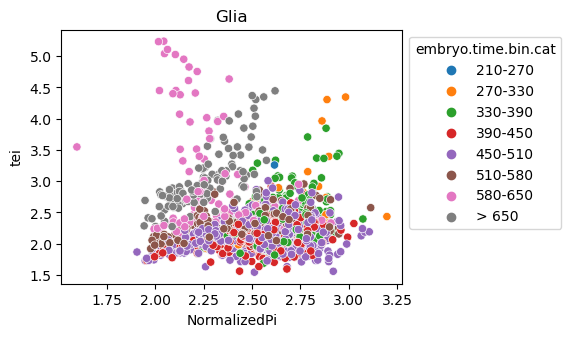

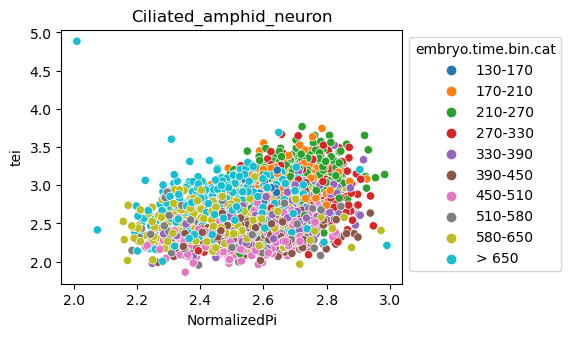

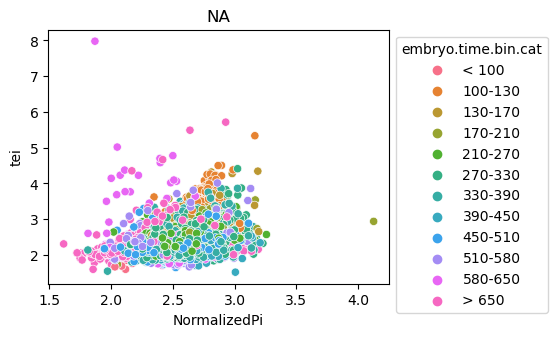

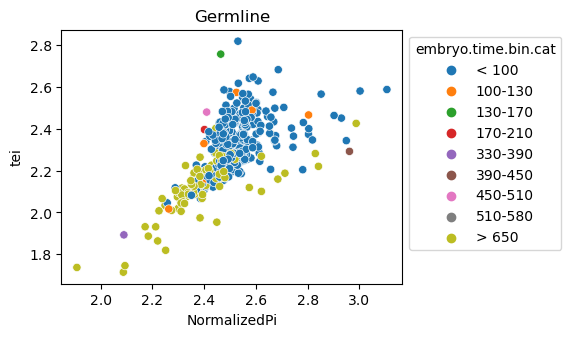

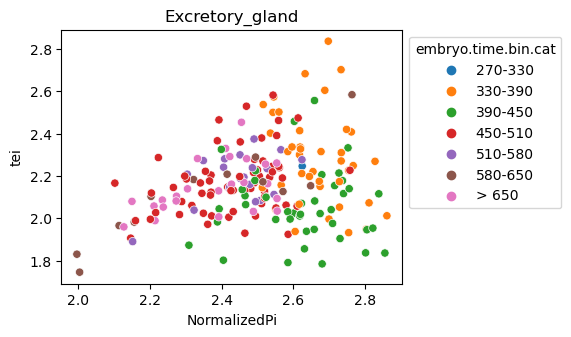

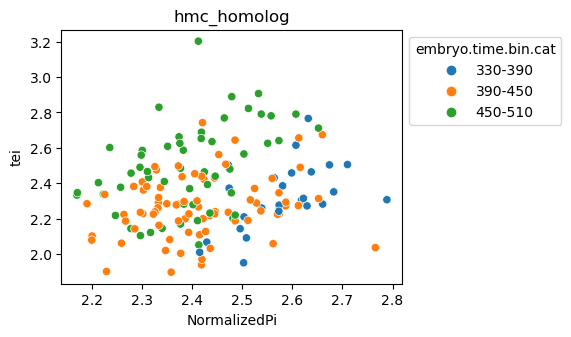

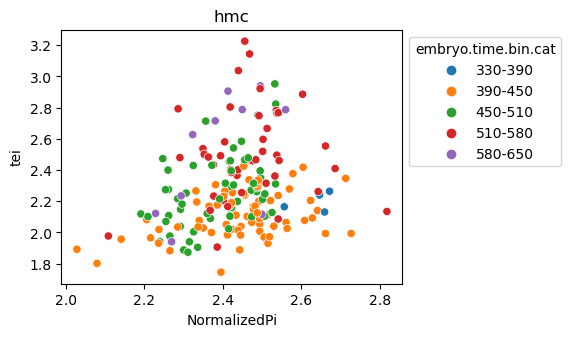

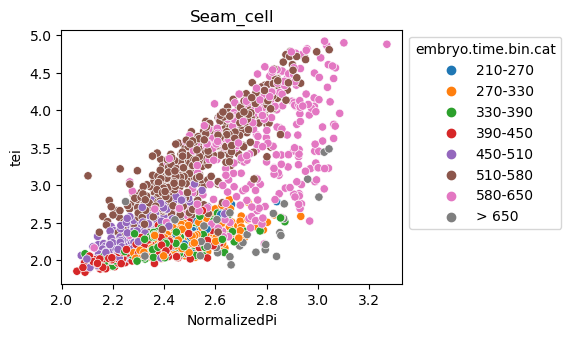

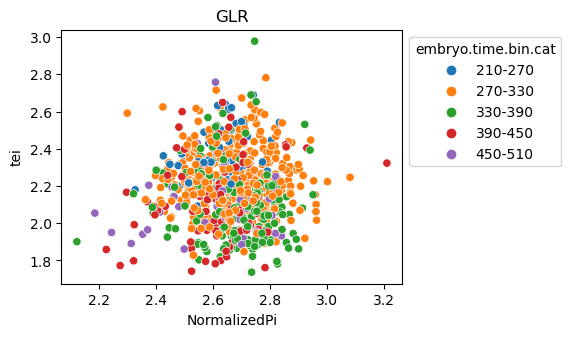

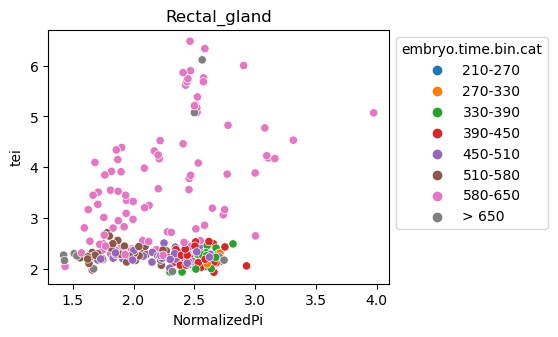

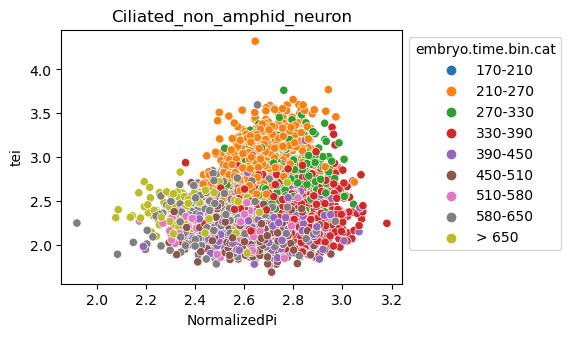

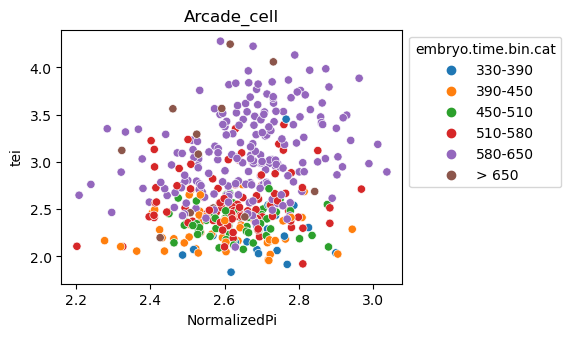

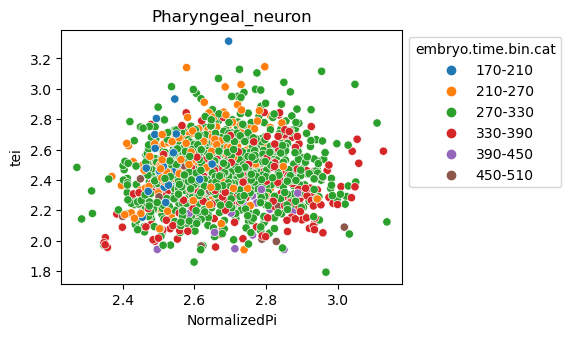

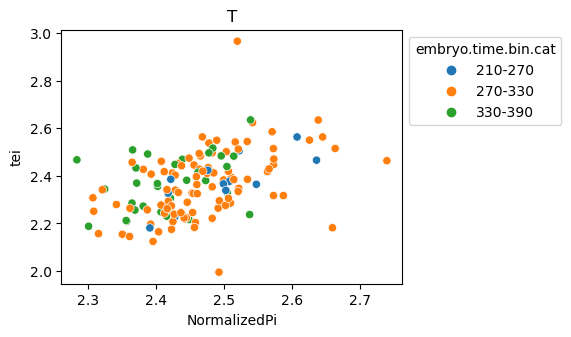

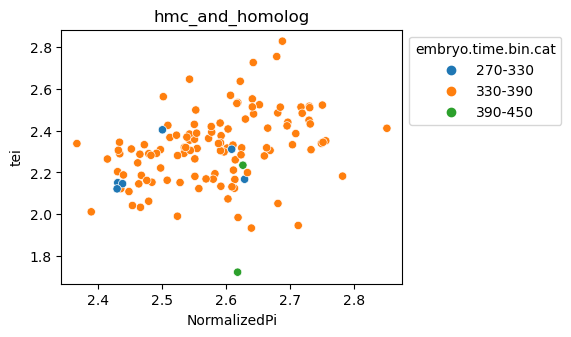

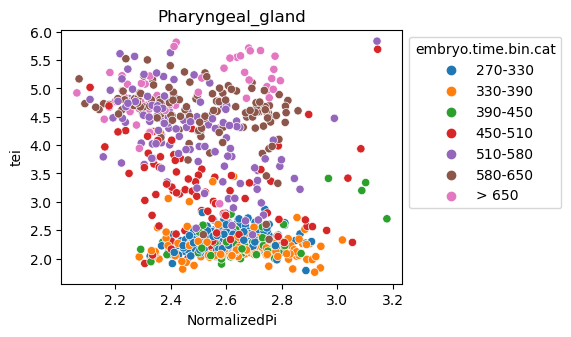

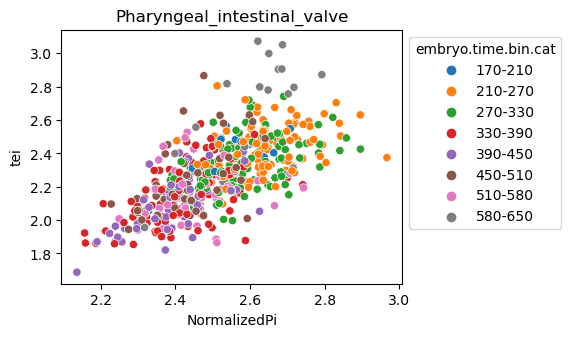

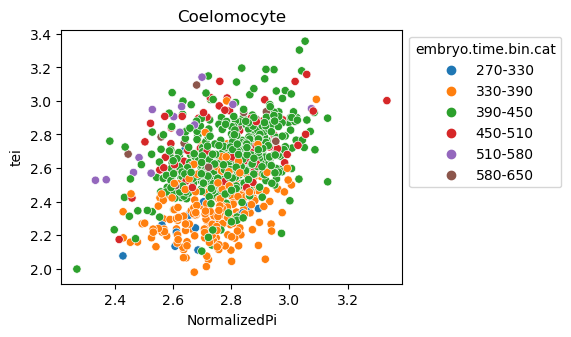

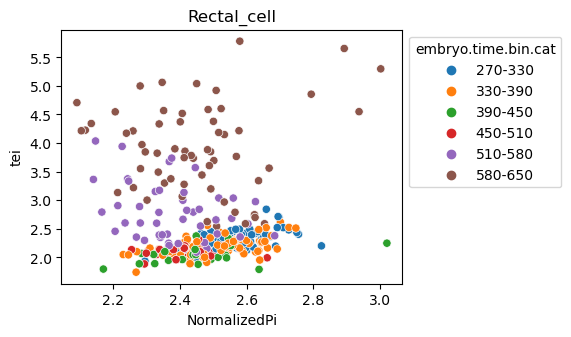

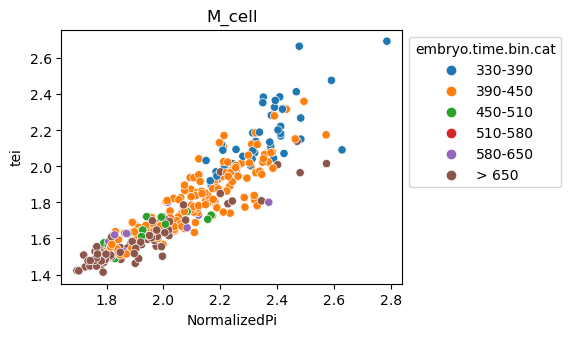

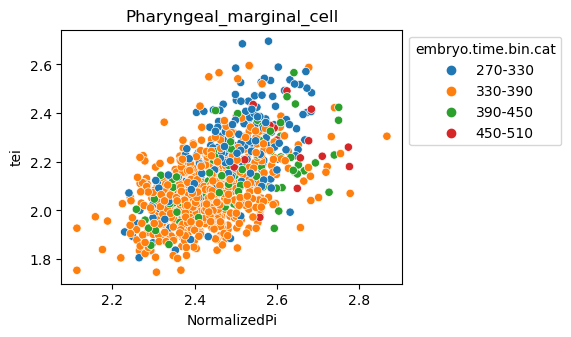

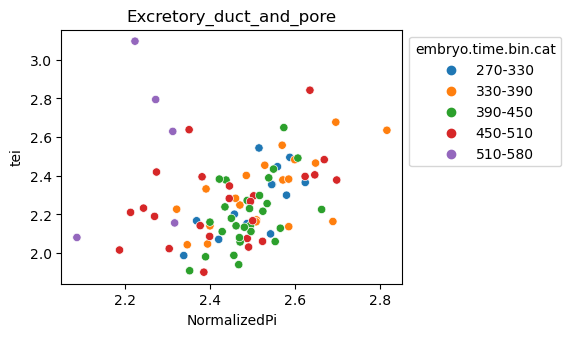

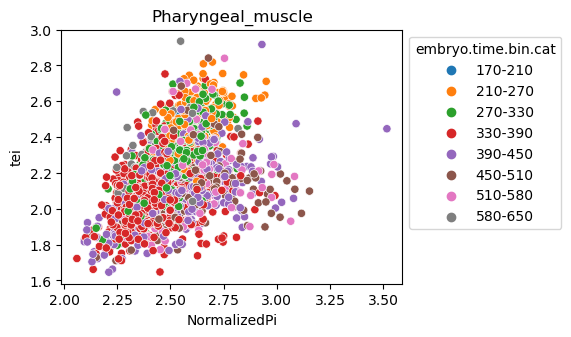

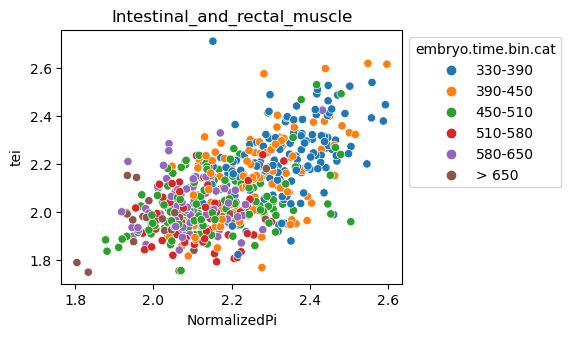

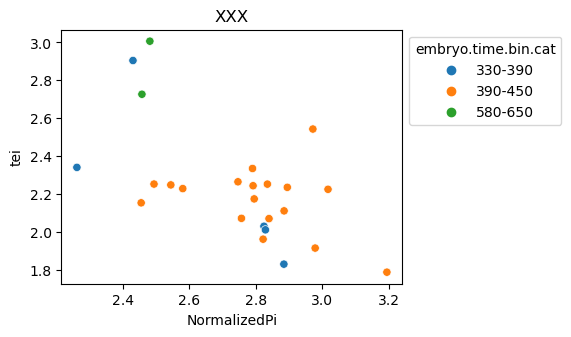

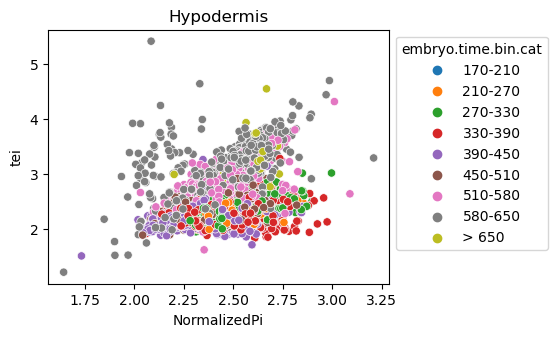

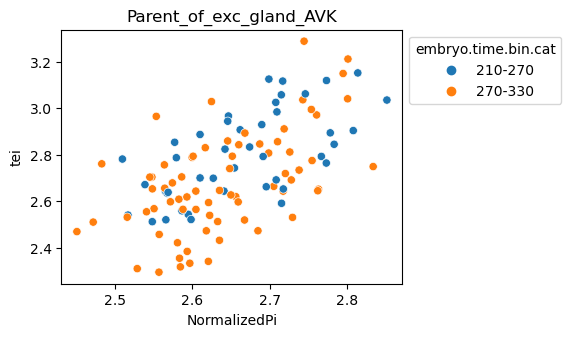

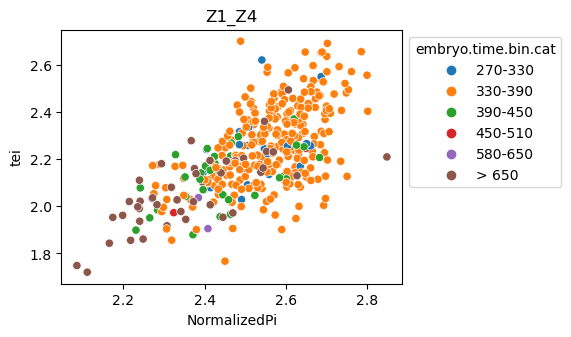

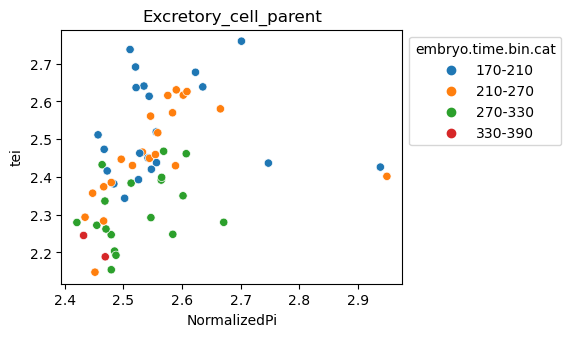

In [28]:
for ct in list(set(celegans_data.obs['cell.type'])):
    ax = sns.scatterplot(data=celegans_data[celegans_data.obs['cell.type']==ct].obs,
            x='NormalizedPi',
            y='tei',
            hue='embryo.time.bin.cat')
    ax.set_title(ct)
    sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
    plt.show()

### Plot relative expression per gene age class per sample timepoint

In [29]:
celegans_data_rematrix_grouped = orthomap2tei.get_rematrix(
    adata=celegans_data,
    gene_id=query_orthomap['GeneID'],
    gene_age=query_orthomap['Phylostratum'],
    keep='min',
    layer=None,
    use='counts',
    var_type='mean',
    group_by_obs='embryo.time.bin.cat',
    obs_fillna='__NaN',
    obs_type='mean',
    standard_scale=0,
    normalize_total=False,
    log1p=False,
    target_sum=1e6)
celegans_data_rematrix_grouped

embryo.time.bin.cat     < 100   100-130   130-170   170-210   210-270  \
ps                                                                      
0                    0.616747  1.000000  0.251017  0.000000  0.041847   
1                    1.000000  0.509469  0.255183  0.076283  0.051693   
2                    1.000000  0.505042  0.379323  0.197721  0.124727   
3                    1.000000  0.451091  0.123908  0.019836  0.014525   
4                    1.000000  0.384635  0.125122  0.000000  0.035642   
5                    1.000000  0.408540  0.325083  0.083223  0.000000   
6                    0.403849  0.155982  0.079791  0.010781  0.000000   
7                    1.000000  0.421741  0.117370  0.020507  0.013733   
8                    1.000000  0.446519  0.297558  0.153997  0.092090   
9                    1.000000  0.271713  0.116398  0.070132  0.098356   
10                   0.769586  0.181758  0.065254  0.000512  0.000000   
11                   0.460530  1.000000  0.293309  0.108577  0.098927   
12                   0.379685  1.000000  0.484752  0.218940  0.157808   
13                   0.259933  1.000000  0.480654  0.234802  0.193773   

embryo.time.bin.cat   270-330   330-390   390-450   450-510   510-580  \
ps                                                                      
0                    0.182806  0.279675  0.198514  0.257970  0.424490   
1                    0.071935  0.065055  0.043788  0.054889  0.018980   
2                    0.077815  0.039156  0.000000  0.013629  0.050892   
3                    0.000000  0.033843  0.001254  0.060600  0.066607   
4                    0.157635  0.203574  0.168511  0.087984  0.182017   
5                    0.002628  0.109071  0.201846  0.110293  0.378627   
6                    0.008198  0.024927  0.032164  0.055423  0.269930   
7                    0.080531  0.058368  0.021998  0.000000  0.008674   
8                    0.045948  0.016749  0.000000  0.011410  0.022365   
9                    0.187239  0.263483  0.109163  0.041041  0.046339   
10                   0.021280  0.017931  0.019221  0.166016  0.650820   
11                   0.052797  0.022248  0.000468  0.000000  0.128757   
12                   0.100249  0.054549  0.012694  0.000000  0.039416   
13                   0.152217  0.092479  0.035109  0.023655  0.004934   

embryo.time.bin.cat   580-650     > 650  
ps                                       
0                    0.614716  0.171721  
1                    0.000000  0.233497  
2                    0.040865  0.184412  
3                    0.075380  0.584756  
4                    0.128194  0.309702  
5                    0.453606  0.823422  
6                    1.000000  0.444653  
7                    0.107050  0.227831  
8                    0.033479  0.125245  
9                    0.000000  0.135193  
10                   0.837500  1.000000  
11                   0.220773  0.016201  
12                   0.089807  0.043030  
13                   0.000000  0.043418

corresponds to main figure Figure 1E

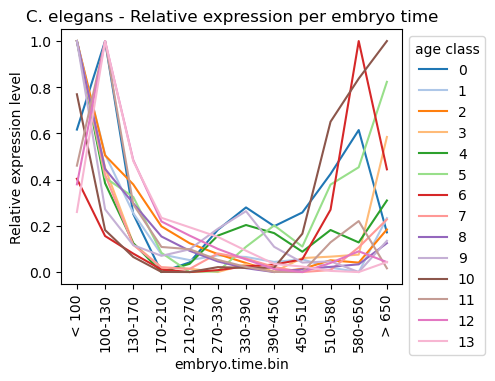

In [30]:
ax = sns.lineplot(celegans_data_rematrix_grouped.transpose(), palette='tab20', dashes=False)
ax.legend(fontsize=5, title='age class')
ax.set_title('C. elegans - Relative expression per embryo time')
ax.set_xlabel('embryo.time.bin')
ax.set_ylabel('Relative expression level')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
plt.show()

### Get partial TEI values to visualize gene age class contributions

Partial `TEI` values can give an idea about which gene age class contributed at most to the `global` `TEI` pattern.

In detail, each gene gets a `TEI` contribution profile as follows:

${TEI_is = f_is * ps_i}$

, where ${TEI_is}$ is the partial `TEI` value of gene ${i}$, ${f_is = e_is / \sum e_is}$ and ${ps_i}$ is the phylostratum of gene i.

${TEI_is}$ values are combined per ${ps}$.

The partial `TEI` values combined per strata give an overall impression of the contribution of each strata to the `global` `TEI` pattern.

One can either start from `counts` (`adata.X`) which is set as default or any other `layer` defined by the `layer` option (`layer=None`).

In addition, the `counts` can be `normalized` and `log-transformed` prior calculating partial `TEI` values (`normalize_total=False`, `log1p=False`, `target_sum=1e6`).

Further, these values can be combined per given observation, e.g. sample timepoint (`group_by='raw.embryo.time'`).

The `get_pstrata` function of the `orthomap2tei` submodule will return two matrix, the first contains the sum of each partial `TEI` per gene age class and the second the corresponding frequencies.

Both can be further processed by returning the `cumsum` over the gene age classes. To get them set the option `cumsum=True`. The `cumsum` will result in either for the first matrix the `TEI` value per cell or mean `TEI` value per group, if one choose a observation with the `group_by` option. Or in case of the second frequency matrix will result in 1.

With the `standard_scale` option either gene age classes (`standard_scale=0` rows) or cells or groups (`standard_scale=1` columns) can be scaled, subtract the minimum and divide each by its maximum. By default no scaling is applied (`standard_scale=None`).

The resulting data will be visualized in the downstream section.

In [31]:
celegans_pstrata = orthomap2tei.get_pstrata(adata=celegans_data,
    gene_id=query_orthomap['GeneID'],
    gene_age=query_orthomap['Phylostratum'],
    keep='min',
    layer=None,
    cumsum=False,
    group_by_obs='raw.embryo.time',
    obs_fillna='__NaN',
    obs_type='mean',
    standard_scale=None,
    normalize_total=False,
    log1p=False,
    target_sum=1e6)
celegans_pstrata[0]

raw.embryo.time       0         5         10        20        40        50   \
ps                                                                            
0                0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1                0.549083  0.574349  0.593155  0.570761  0.577926  0.580294   
2                0.519701  0.497403  0.476214  0.483944  0.477042  0.483123   
3                0.036390  0.033320  0.033268  0.038470  0.034156  0.035035   
4                0.195752  0.190910  0.171847  0.190117  0.196106  0.182067   
5                0.039479  0.035305  0.032354  0.040338  0.034246  0.036710   
6                0.014067  0.015403  0.014391  0.013885  0.013951  0.013708   
7                0.141373  0.143424  0.132741  0.142134  0.132484  0.136642   
8                0.175545  0.152894  0.145318  0.150978  0.139066  0.149923   
9                0.127472  0.139071  0.113317  0.131446  0.117364  0.139956   
10               0.030569  0.022373  0.017681  0.024292  0.022067  0.024570   
11               0.226659  0.182175  0.186109  0.208851  0.226264  0.198116   
12               0.193541  0.163035  0.175392  0.183838  0.188269  0.169305   
13               0.110977  0.073815  0.103908  0.111685  0.117343  0.116932   

raw.embryo.time       60        70        100       120  ...       550  \
ps                                                       ...             
0                0.000000  0.000000  0.000000  0.000000  ...  0.000000   
1                0.570177  0.561362  0.515519  0.503397  ...  0.474549   
2                0.496792  0.447250  0.416455  0.471573  ...  0.541008   
3                0.034535  0.035977  0.038326  0.029253  ...  0.053843   
4                0.190356  0.200345  0.167553  0.169573  ...  0.250337   
5                0.035632  0.032066  0.029407  0.034641  ...  0.083369   
6                0.011269  0.012910  0.011674  0.010866  ...  0.040299   
7                0.132616  0.125686  0.124445  0.097068  ...  0.089024   
8                0.146914  0.133009  0.102429  0.116111  ...  0.065694   
9                0.128932  0.107984  0.078723  0.075290  ...  0.109117   
10               0.024531  0.020520  0.015681  0.014540  ...  0.102762   
11               0.203334  0.344744  0.615578  0.510605  ...  0.330443   
12               0.187002  0.313091  0.593787  0.575718  ...  0.218935   
13               0.100828  0.224558  0.488242  0.510101  ...  0.077592   

raw.embryo.time       620       630       640       700       750       760  \
ps                                                                            
0                0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1                0.467104  0.401179  0.446233  0.509904  0.520108  0.526689   
2                0.532387  0.532372  0.539955  0.542670  0.553268  0.557351   
3                0.054917  0.064067  0.057452  0.060818  0.062612  0.060669   
4                0.225944  0.274310  0.225154  0.203085  0.202924  0.204547   
5                0.078667  0.103242  0.077916  0.079211  0.084068  0.074992   
6                0.077255  0.160162  0.080864  0.054299  0.057766  0.052968   
7                0.099810  0.105424  0.143029  0.139323  0.128307  0.136390   
8                0.070210  0.071257  0.071980  0.084810  0.082965  0.084456   
9                0.098914  0.083293  0.098941  0.115277  0.109113  0.102357   
10               0.093731  0.083826  0.151510  0.120387  0.079833  0.065175   
11               0.390670  0.537535  0.395574  0.160831  0.141096  0.130801   
12               0.252136  0.349198  0.272818  0.197370  0.174126  0.144126   
13               0.076376  0.064393  0.058599  0.071850  0.067551  0.059868   

raw.embryo.time       800       810       830  
ps                                             
0                0.000000  0.000000  0.000000  
1                0.514210  0.550763  0.576298  
2                0.576492  0.538513  0.469141  
3                0.059437  0.057598  0.053565

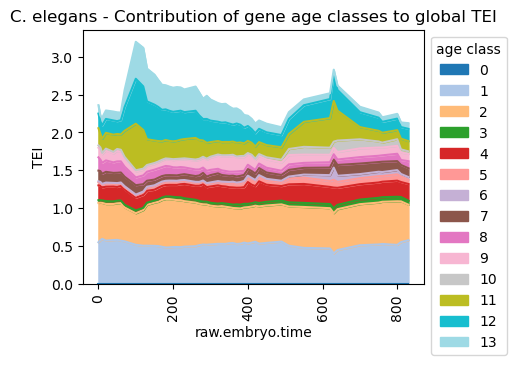

In [32]:
ax=celegans_pstrata[0].transpose().plot.area(cmap='tab20')
ax.legend(fontsize=3, title='age class')
ax.set_title('C. elegans - Contribution of gene age classes to global TEI')
ax.set_xlabel('raw.embryo.time')
ax.set_ylabel('TEI')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
plt.show()

#### partial TajimaD

__Note:__ Please change notebook cell from `raw` to `code` to see the plots.

__Note:__ Please change notebook cell from `raw` to `code` to see the plots.

#### partial Fst

__Note:__ Please change notebook cell from `raw` to `code` to see the plots.

__Note:__ Please change notebook cell from `raw` to `code` to see the plots.

#### partial NormalizedPi

__Note:__ Please change notebook cell from `raw` to `code` to see the plots.

__Note:__ Please change notebook cell from `raw` to `code` to see the plots.

### Color UMAP/TSNE by TEI

Follwoing the basic tutorial of the Scanpy python toolkit ([Wolf et al., 2018](https://doi.org/10.1186/s13059-017-1382-0)), one can highlight `TEI` values on a dimensional reduction of the scRNA dataset, like `PCA`, `UMAP` or `TSNE`.

#### Filtering

In [33]:
sc.pp.filter_genes(celegans_data, min_cells=3)
sc.pp.filter_cells(celegans_data, min_genes=200)

#### Normalization, Log transformation and Scaling

In [34]:
sc.pp.normalize_total(celegans_data, target_sum=1e6)
sc.pp.log1p(celegans_data)
sc.pp.scale(celegans_data, max_value=10)

#### PCA and Neighbor calculations

/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


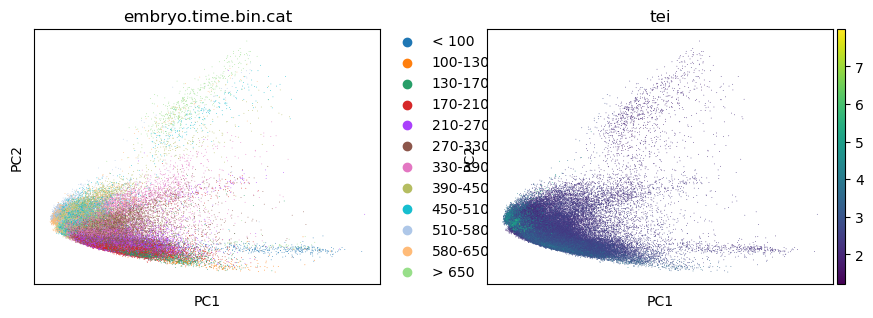

In [35]:
sc.tl.pca(celegans_data, svd_solver='arpack')
sc.pl.pca(celegans_data, color=['embryo.time.bin.cat', 'tei'])

In [36]:
sc.pp.neighbors(celegans_data)

#### Embedding the neighborhood graph

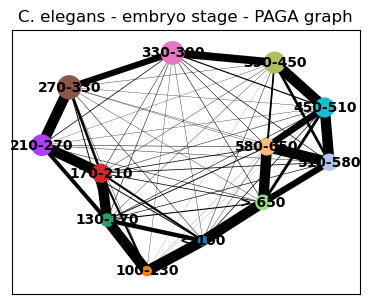

In [37]:
sc.tl.paga(celegans_data, groups='embryo.time.bin.cat')
sc.pl.paga(celegans_data, title='C. elegans - embryo stage - PAGA graph')

#### UMAP

/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


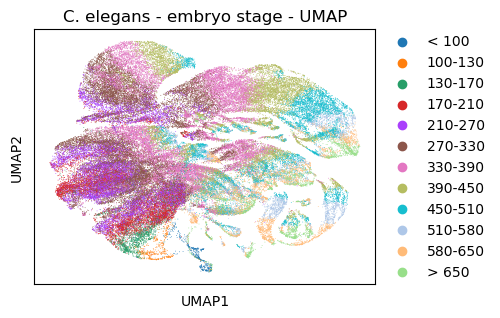

In [38]:
sc.tl.umap(celegans_data,
           init_pos='paga')
sc.pl.umap(celegans_data,
           title='C. elegans - embryo stage - UMAP', color=['embryo.time.bin.cat'])

#### Color UMAP by cell type

/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


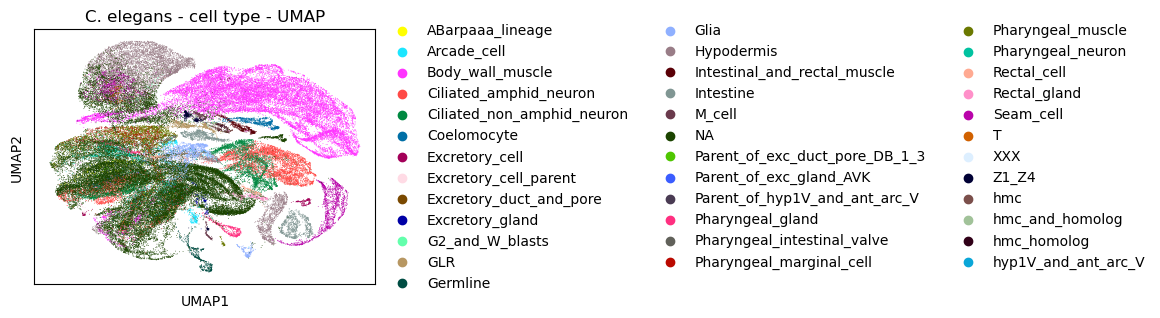

In [39]:
sc.pl.umap(celegans_data,
           title='C. elegans - cell type - UMAP', color=['cell.type'])

#### Color UMAP by TEI

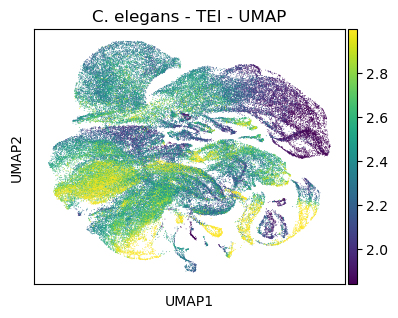

In [40]:
#plt.rcParams['figure.figsize'] = [7.5, 4.5]
sc.pl.umap(celegans_data,
           title='C. elegans - TEI - UMAP',
           color=['tei'],
           color_map='viridis',
           vmin='p5',
           vmax='p95')
#plt.rcParams['figure.figsize'] = [6, 4.5]

#### Color UMAP by TajimaD bins

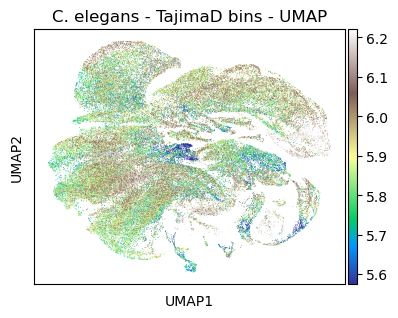

In [41]:
#plt.rcParams['figure.figsize'] = [7.5, 4.5]
sc.pl.umap(celegans_data,
           title='C. elegans - TajimaD bins - UMAP',
           color=['TajimaD'],
           color_map='terrain',
           vmin='p5',
           vmax='p95')
#plt.rcParams['figure.figsize'] = [6, 4.5]

#### Color UMAP by Fst bins

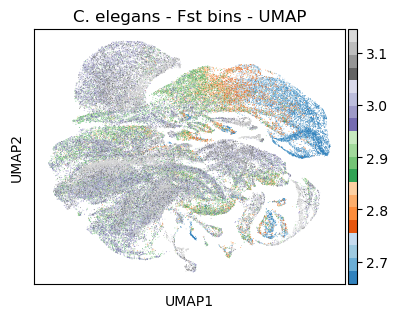

In [42]:
#plt.rcParams['figure.figsize'] = [7.5, 4.5]
sc.pl.umap(celegans_data,
           title='C. elegans - Fst bins - UMAP',
           color=['Fst'],
           color_map='tab20c',
           vmin='p5',
           vmax='p95')
#plt.rcParams['figure.figsize'] = [6, 4.5]

#### Color UMAP by NormalizedPi bins

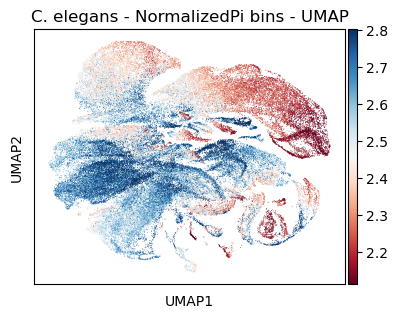

In [43]:
#plt.rcParams['figure.figsize'] = [7.5, 4.5]
sc.pl.umap(celegans_data,
           title='C. elegans - NormalizedPi bins - UMAP',
           color=['NormalizedPi'],
           color_map='RdBu',
           vmin='p5',
           vmax='p95')
#plt.rcParams['figure.figsize'] = [6, 4.5]